In [1]:
import os
import random
import math
import pickle
from matplotlib import pyplot as plt
import skimage
import sklearn
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import umap
import seaborn as sns

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Read the images
X = []
Y = []

for cls in os.listdir("data/processed"):
  for img_filename in os.listdir(f"data/processed/{cls}"):
    img = skimage.io.imread(f"data/processed/{cls}/{img_filename}")
    X.append(img)
    Y.append(cls)

# Convert to numpy
X = np.array(X, dtype = np.uint8)
Y = sklearn.preprocessing.LabelEncoder().fit_transform(Y)

# Split the data
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, random_state = 42, stratify = Y)

In [3]:
np.random.seed(seed)
open_set = {}
for k_openset in range(5, 0, -1):
  open_set[k_openset] = {}
  size = round(len(np.unique(Y)) * (k_openset / 10))
  for kfold in range(5):
    open_set[k_openset][kfold] = np.random.choice(np.unique(Y), size = size, replace = False)

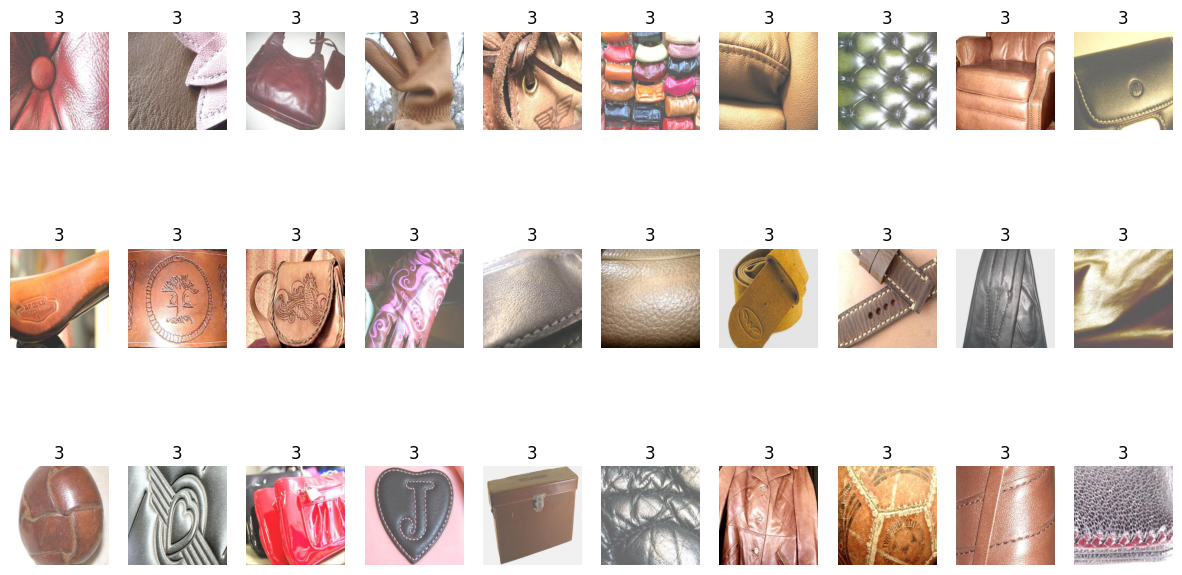

In [4]:
# Visualize some images and their corresponding labels.
plt.figure(figsize = (15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X[i] / 255.)
  plt.title(Y[i])
  plt.axis("off")

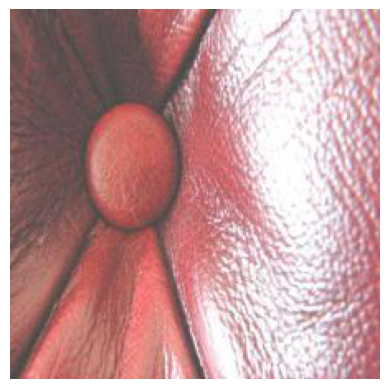

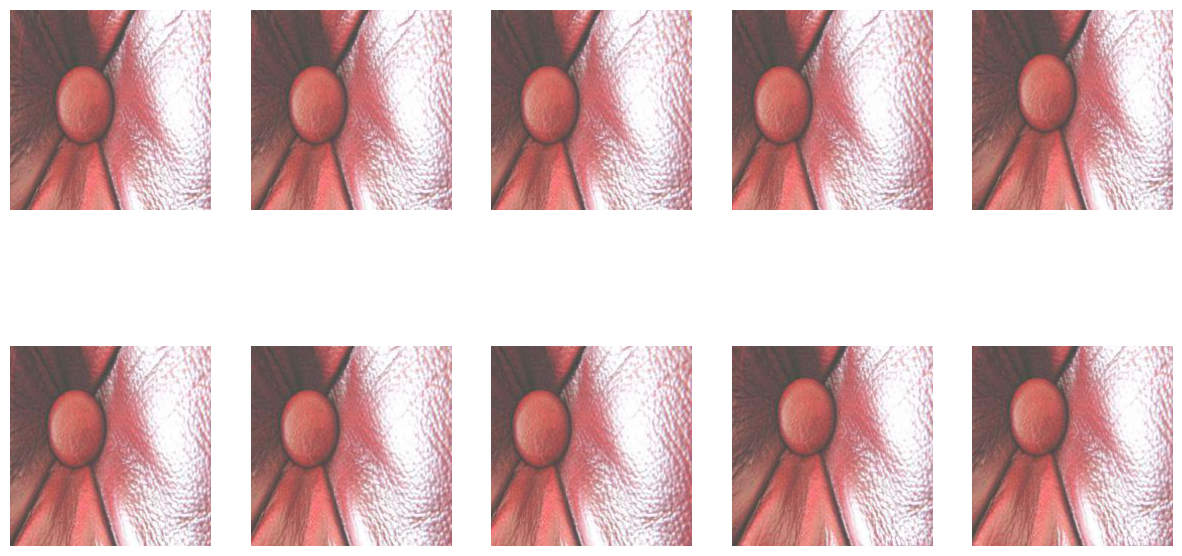

In [5]:
def gen_patches(img, patch_size, min_patches = None, regular = True):

  # This function generates patches from an input image.
  # 'img' is the input image, 'patch_size' is a tuple indicating the height and width of each patch.
  # 'min_patches' is the minimum number of patches required, and 'regular' is a boolean that, when False, allows irregular patch distribution.

  # Gets the shape of the input image.
  input_shape = img.shape

  # Calculates the minimum number of rows and columns of patches to cover the image.
  n_rows = math.ceil(input_shape[0] / patch_size[0])
  n_cols = math.ceil(input_shape[1] / patch_size[1])

  # Total number of patches.
  n_patches = n_rows * n_cols

  # Adjusts the number of rows and columns to ensure at least 'min_patches' patches are created.
  if min_patches is not None:
    while min_patches > n_patches:
      row_ratio = input_shape[0] / n_rows / patch_size[0]
      col_ratio = input_shape[1] / n_cols / patch_size[1]
      if row_ratio > col_ratio:
        n_rows += 1
      else:
        n_cols += 1
      n_patches = n_rows * n_cols

  # Calculates overlap between patches.
  row_overlap = math.ceil(((patch_size[0] * n_rows) - input_shape[0]) / (n_rows - 1))
  col_overlap = math.ceil(((patch_size[1] * n_cols) - input_shape[1]) / (n_cols - 1))

  # Generate all starting pixels, except the last one.
  row_patches = np.arange(0, input_shape[0], patch_size[0] - row_overlap)[0:(n_rows - 1)]
  col_patches = np.arange(0, input_shape[1], patch_size[1] - col_overlap)[0:(n_cols - 1)]

  # Create the last starting pixel manually to avoid going larger than the input image.
  row_patches = np.append(row_patches, input_shape[0] - patch_size[0])
  col_patches = np.append(col_patches, input_shape[1] - patch_size[1])

  # Generate rows and cols patches.
  row_patches = [(i, i + patch_size[0]) for i in row_patches]
  col_patches = [(i, i + patch_size[1]) for i in col_patches]

  # Combine them
  patches_indices = [(i, j) for i in row_patches for j in col_patches]

  # If not regular, then drop some patches to match min_patches
  if not regular:
    n_drop = n_patches - min_patches
    if n_drop > 0:
      # Generate random indices to delete
      drop_indices = random.sample(range(n_patches), n_drop)
      # Create a new list without the selected elements
      patches_indices = [patches_indices[i] for i in range(n_patches) if i not in drop_indices]
      # Update the number of patches
      n_patches = min_patches

  patches = np.zeros((n_patches, patch_size[0], patch_size[1], input_shape[2]), dtype = np.float32)

  # Extract patches from the image based on calculated indices.
  for patch_i in range(n_patches):
    row, col = patches_indices[patch_i]
    patches[patch_i] = img[row[0]:row[1], col[0]:col[1], :]

  # Normalize the patches if the image data type is 'uint8'.
  if img.dtype == "uint8":
    patches = (patches / 255).astype(np.float32)

  return patches

# Demonstration of using the 'gen_patches' function.
plt.imshow(X[0])
plt.axis("off")

# Generates patches from the first image in 'X'.
patches = gen_patches(X[0], (200, 200), min_patches = 10, regular = True)
plt.figure(figsize = (15, 8))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(patches[i])
  plt.axis("off")

In [6]:
# Create a function for generating batches of pairs
def get_pair_batch(batch_size, X, Y, augment = False, device = None):

  # Randomly select batch_size number of classes
  classes = np.random.choice(np.unique(Y), size = batch_size, replace = True)

  # Initialize arrays to store the pairs and their classes
  pairs = [torch.zeros((batch_size, 3, 200, 200), dtype = torch.float32) for _ in range(2)]

  # Store the classes for later filtering of positive and negative samples
  pairs.append(torch.from_numpy(classes))

  # Define the augmentation pipeline
  transform = A.Compose([
    A.RandomCrop(200, 200),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.GaussianBlur(),
    A.RandomBrightnessContrast(),
    ToTensorV2()
  ])

  for i in range(batch_size):

    # Get indices of all samples that belong to the chosen class
    choices = np.where(Y == classes[i])[0]

    # Randomly select two samples of the same class
    idx_A = np.random.choice(choices)
    idx_B = np.random.choice(choices)

    if augment:
      img_A = transform(image = X[idx_A])["image"]
      img_B = transform(image = X[idx_B])["image"]
    else:
      img_A = ToTensorV2()(image = X[idx_A])["image"]
      img_B = ToTensorV2()(image = X[idx_B])["image"]

    # Save the samples to the pair list
    pairs[0][i] = img_A / 255.
    pairs[1][i] = img_B / 255.

  # Move the pairs to the device
  if device is not None:
    pairs[0] = pairs[0].to(device)
    pairs[1] = pairs[1].to(device)
    pairs[2] = pairs[2].to(device)

  return pairs

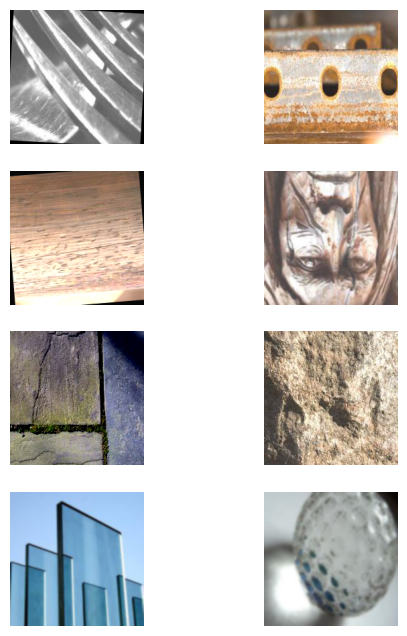

In [7]:
# Genrating some augmented examples.
pair = get_pair_batch(4, X, Y, augment = True)

plt.figure(figsize = (6, 8))
for i in range(4):
  ax = plt.subplot(4, 2, i * 2 + 1)
  plt.imshow(np.transpose(pair[0][i].numpy(), (1, 2, 0)))
  plt.axis("off")
  ax = plt.subplot(4, 2, i * 2 + 2)
  plt.imshow(np.transpose(pair[1][i].numpy(), (1, 2, 0)))
  plt.axis("off")

In [8]:
# PyTorch data utils
def img_to_torch(batch, device = None):

  # Define the transformations
  transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
  ])

  # Apply the transform to the batch of images
  batch = torch.stack([transform(im) for im in batch])

  if device is not None:
    # Move data to device
    batch = batch.to(device)

  return (batch)

class PatchData(torch.utils.data.Dataset):
  def __init__(self, data, device = None):
    self.data = data
    self.device = device
    self.size = self.data.shape[0]

  def __getitem__(self, index):
    patches = gen_patches(self.data[index], (200, 200))
    return img_to_torch(patches, self.device)

  def __len__(self):
    return self.size

In [9]:
# NT-Xent loss function
class NTXentLoss(torch.nn.Module):
  def __init__(self, temperature = 0.5):
    super(NTXentLoss, self).__init__()
    self.temperature = temperature

  def forward(self, diss, y):
    size = diss.shape[0]

    # Mask for positive samples
    y = torch.cat([y, y], dim = 0)
    y1 = torch.tile(y, [size])
    y2 = torch.repeat_interleave(y, size, axis = 0)
    pos_mask = torch.reshape(y1 == y2, (size, size))
    pos_mask.diagonal().fill_(False)

    # Mask for negative samples
    neg_mask = (~torch.eye(size, size, device = diss.device, dtype = bool)).float()

    # Compute nominator
    nominator = torch.sum(pos_mask * torch.exp(diss / self.temperature), dim = 1)

    # Compute denominator
    denominator = torch.sum(neg_mask * torch.exp(diss / self.temperature), dim = 1)

    # Compute loss
    loss_partial = -torch.log(nominator / denominator)
    loss = torch.mean(loss_partial)

    return loss

# Base network
class Network(torch.nn.Module):
  def __init__(self, embeddingsize):
    super(Network, self).__init__()

    # Load EfficientNetV2-S as the shared network
    self.network = torchvision.models.get_model("efficientnet_v2_s", weights = "DEFAULT")

    # Freeze the base network
    for param in self.network.parameters():
      param.requires_grad = False

    # Replace the last classification layer with a set of custom layers
    self.network.classifier = torch.nn.Sequential(
      torch.nn.Linear(self.network.classifier[1].in_features, 512),
      torch.nn.ReLU(),
      torch.nn.Dropout(p = 0.2),
      torch.nn.Linear(512, 256),
      torch.nn.ReLU(),
      torch.nn.Dropout(p = 0.2),
      torch.nn.Linear(256, embeddingsize)
    )

  def forward(self, x):
    # Pass the input through the shared network
    x = self.network(x)

    # Normalize the embedding vectors
    embedding = torch.nn.functional.normalize(x, p = 2, dim = 1)

    return embedding

# Projection head
class ProjectionHead(torch.nn.Module):
  def __init__(self, embeddingsize):
    super(ProjectionHead, self).__init__()

    self.projection_head = torch.nn.Sequential(
      torch.nn.Linear(embeddingsize, embeddingsize // 2),
      torch.nn.ReLU(),
      torch.nn.Linear(embeddingsize // 2, embeddingsize // 4),
      torch.nn.ReLU(),
      torch.nn.Linear(embeddingsize // 4, 1)
    )

  def forward(self, x1, x2):
    return self.projection_head(torch.abs(x1 - x2))

# Contrastive model
class ContrastiveModel(torch.nn.Module):
  def __init__(self, embeddingsize):
    super(ContrastiveModel, self).__init__()
    self.network = Network(embeddingsize)
    self.projection_head = ProjectionHead(embeddingsize)

  def forward(self, x1, x2):

    # Encode the inputs
    x1 = self.network(x1)
    x2 = self.network(x2)

    if self.training:
      batch_size = x1.shape[0]

      # Repeat the elements to match the input expected the network
      x = torch.cat([x1, x2])
      x1 = torch.tile(x, [batch_size * 2, 1])
      x2 = torch.repeat_interleave(x, batch_size * 2, axis = 0)

      dissimilarity = self.projection_head(x1, x2)
      dissimilarity = torch.reshape(dissimilarity, (batch_size * 2, -1))

    else:
      dissimilarity = self.projection_head(x1, x2)

    return (dissimilarity)

  def freeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = False

  def unfreeze_network(self):
    for param in self.network.parameters():
      param.requires_grad = True

In [10]:
def train_model(X, Y, model_id, embeddingsize = 128, temperature = 0.5,
                batch_size = 32, iterations = 10000):

  # Define the model filename based on model_id
  model_filename = f"models/contr_{model_id}.pth"
  print(model_filename)

  # Define computation device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  contr_model = None

  # Load pre-trained model if exists
  if os.path.isfile(model_filename):
    contr_model = ContrastiveModel(embeddingsize)
    contr_model.load_state_dict(torch.load(model_filename))
    contr_model.to(device)

  # Train a new model if not loaded
  if contr_model is None:

    contr_model = ContrastiveModel(embeddingsize)
    contr_model.to(device)

    # Initialize loss, optimizer, and training mode
    contr_loss = NTXentLoss(temperature)
    optimizer = torch.optim.SGD(contr_model.parameters(), lr = 0.01, momentum = 0.9)
    contr_model.train()

    print("Warmup")

    # Warmup top layers
    train_loss = 0
    for i in range(10):
      for _ in range(100):
        x1, x2, y = get_pair_batch(batch_size, X, Y, augment = True, device = device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = contr_model(x1, x2)

        # Compute loss
        loss = contr_loss(outputs, y)
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Compute average loss
      print(f"Epoch {i + 1}, Loss: {train_loss / 100:.4f}")
      train_loss = 0

    print("Training")

    # Unfreeze the network
    contr_model.unfreeze_network()

    # Add a learning rate scheduler with linear warmup
    optimizer = torch.optim.SGD(contr_model.parameters(), lr = 0.001, momentum = 0.9)

    # Train
    train_loss = 0
    for i in range(iterations // 100):
      for _ in range(100):
        x1, x2, y = get_pair_batch(batch_size, X, Y, augment = True, device = device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = contr_model(x1, x2)

        # Compute loss
        loss = contr_loss(outputs, y)
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

      # Compute average loss
      print(f"Epoch {i + 1}, Loss: {train_loss / 100:.4f}")
      train_loss = 0

    # Save the trained model
    torch.save(contr_model.state_dict(), model_filename)

  # Freeze the model parameters
  for param in contr_model.parameters():
    param.requires_grad = False

  # Set to evaluation mode
  contr_model.eval()

  return contr_model

In [11]:
# Model training
models = {}

# Iterate over the different openset splits
for k_openset in range(5, 0, -1):
  models[k_openset] = {}
  for kfold in range(5):

    # Remove the openset classes
    openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
    X_train_open = X_train[openset_indices]
    Y_train_open = Y_train[openset_indices]

    # Unique model identifier
    model_id = f"fold-{kfold}_open-{k_openset}"

    # Train the model
    models[k_openset][kfold] = train_model(X_train_open, Y_train_open,
                                           model_id = model_id, iterations = 15000)

models/contr_fold-0_open-5.pth


/tmp/ipykernel_104976/2904293122.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  contr_model.load_state_dict(torch.load(model_filename))


models/contr_fold-1_open-5.pth
models/contr_fold-2_open-5.pth
models/contr_fold-3_open-5.pth
models/contr_fold-4_open-5.pth
models/contr_fold-0_open-4.pth
models/contr_fold-1_open-4.pth
models/contr_fold-2_open-4.pth
models/contr_fold-3_open-4.pth
models/contr_fold-4_open-4.pth
models/contr_fold-0_open-3.pth
models/contr_fold-1_open-3.pth
models/contr_fold-2_open-3.pth
models/contr_fold-3_open-3.pth
models/contr_fold-4_open-3.pth
models/contr_fold-0_open-2.pth
models/contr_fold-1_open-2.pth
models/contr_fold-2_open-2.pth
models/contr_fold-3_open-2.pth
models/contr_fold-4_open-2.pth
models/contr_fold-0_open-1.pth
models/contr_fold-1_open-1.pth
models/contr_fold-2_open-1.pth
models/contr_fold-3_open-1.pth
models/contr_fold-4_open-1.pth


In [12]:
encoddings_filename = "cache/contr-encoddings.pkl"

if (os.path.isfile(encoddings_filename)):
  f = open(encoddings_filename, "rb")
  encoded = pickle.load(f)
  f.close()

else:
  encoded = {}

  # Iterate over the different openset splits
  for k_openset in range(5, 0, -1):
    encoded[k_openset] = {}
    for kfold in range(5):
      encoded[k_openset][kfold] = {}

      # Remove the openset classes
      openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
      X_train_open = X_train[openset_indices]

      contr_model = models[k_openset][kfold]

      # Set the patch loaders
      train_patch_data = PatchData(X_train_open, torch.device("cuda"))
      train_patch_dataloader = torch.utils.data.DataLoader(dataset = train_patch_data, batch_size = None, shuffle = False)

      test_patch_data = PatchData(X_test, torch.device("cuda"))
      test_patch_dataloader = torch.utils.data.DataLoader(dataset = test_patch_data, batch_size = None, shuffle = False)

      # Extract patches from X_train_open
      train_embeddings = torch.stack([contr_model.network(data) for batch_idx, data in enumerate(train_patch_dataloader)])

      # Convert to numpy and compute the mean for each sample
      train_embeddings = np.array(train_embeddings.cpu(), dtype = np.float32)
      encoded[k_openset][kfold]["train"] = np.mean(train_embeddings, axis = 1)

      # Extract patches from X_test
      test_embeddings = torch.stack([contr_model.network(data) for batch_idx, data in enumerate(test_patch_dataloader)])

      # Convert to numpy and compute the mean for each sample
      test_embeddings = np.array(test_embeddings.cpu(), dtype = np.float32)
      encoded[k_openset][kfold]["test"] = np.mean(test_embeddings, axis = 1)

  f = open(encoddings_filename, "wb")
  pickle.dump(encoded, f, -1)
  f.close()

/tmp/ipykernel_104976/1945313915.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  encoded = pickle.load(f)


/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


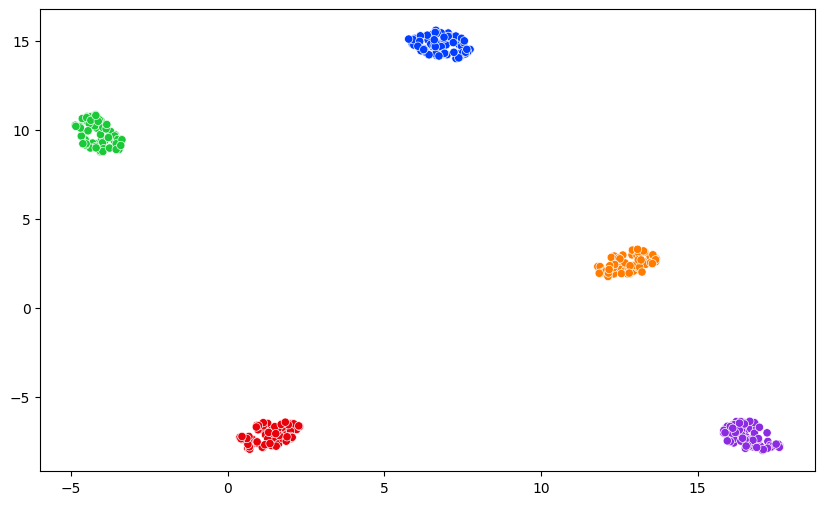

In [13]:
# UMAP to check if the encoddings are good
def draw_umap(encoded_X, Y):
  reducer = umap.UMAP()
  trn = reducer.fit_transform(encoded_X)
  plt.figure(figsize = (10, 6))
  sns.scatterplot(x = trn[:,0], y = trn[:,1], hue = Y, palette = sns.color_palette("bright", len(np.unique(Y))), legend = False)
  plt.show()

k_openset = 5
kfold = 0

# Remove the openset classes
openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
X_train_open = encoded[k_openset][kfold]["train"]
Y_train_open = Y_train[openset_indices]

draw_umap(X_train_open, Y_train_open)

In [14]:
# Prototype selection using clustering methods

# Some clustering methods do not return the centroids
# But the clusters directly, thus we need to compute the centroids manually
def compute_centroids(X, Y, K):
  m, n = X.shape
  centroids = np.zeros((K, n))
  for k in range(K):
    x = X[Y == k]
    centroids[k, :] = np.mean(x, axis = 0)
  return centroids

# Set the number of prototypes per class
n_prototypes = 5

prototypes_filename = "cache/contr-prototypes.pkl"
if (os.path.isfile(prototypes_filename)):
  f = open(prototypes_filename, "rb")
  prototypes = pickle.load(f)
  f.close()

else:
  prototypes = {}

  # Iterate over the different openset splits
  for k_openset in range(5, 0, -1):
    prototypes[k_openset] = {}
    for kfold in range(5):
      prototypes[k_openset][kfold] = {}

      # Remove the openset classes
      openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
      X_prot = encoded[k_openset][kfold]["train"]
      Y_train_open = Y_train[openset_indices]

      # Count the number of unique classes in the training data
      uniq_classes = np.unique(Y_train_open)
      n_classes = len(uniq_classes)

      # Compute the total number of prototypes
      total_prototypes = n_classes * n_prototypes

      prototypes[k_openset][kfold] = np.zeros((total_prototypes, 128), dtype = np.float32)

      # Find prototypes in each class
      for idx, cls in enumerate(uniq_classes):
        X_embedding = X_prot[np.where(Y_train_open == cls)]
        start, end = n_prototypes * (idx + 1) - n_prototypes, n_prototypes * (idx + 1)

        # K-means
        kmeans = sklearn.cluster.KMeans(n_clusters = n_prototypes, init = "k-means++", n_init = "auto", random_state = 1234).fit(X_embedding)
        centroids = kmeans.cluster_centers_
        prototypes[k_openset][kfold][start:end, :] = centroids

  f = open(prototypes_filename, "wb")
  pickle.dump(prototypes, f, -1)
  f.close()

/tmp/ipykernel_104976/2783060959.py:19: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  prototypes = pickle.load(f)


/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


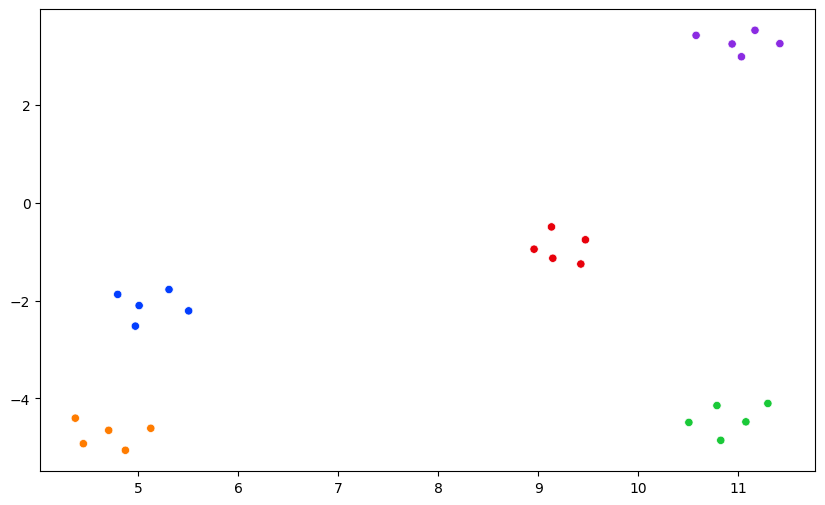

In [15]:
# UMAP to check if the prototypes are good
k_openset = 5
kfold = 0

openset_indices = ~np.isin(Y, open_set[k_openset][kfold])
Y_train_open = Y[openset_indices]

X_prot = prototypes[k_openset][kfold]
Y_prot = np.array([item for item in np.unique(Y_train_open) for _ in range(n_prototypes)])

draw_umap(X_prot, Y_prot)

In [16]:
# Contrastive dissimilarity space
contr_space_filename = "cache/contr-space.pkl"
if (os.path.isfile(contr_space_filename)):
  f = open(contr_space_filename, "rb")
  contr_space = pickle.load(f)
  f.close()

else:
  contr_space = {}

  # Iterate over the different openset splits
  for k_openset in range(5, 0, -1):
    contr_space[k_openset] = {}
    for kfold in range(5):
      contr_space[k_openset][kfold] = {}

      for kset in ["train", "test"]:

        x = encoded[k_openset][kfold][kset]
        y = prototypes[k_openset][kfold]

        n_enc = x.shape[0]
        n_prot = y.shape[0]

        x = np.repeat(x, n_prot, axis = 0)
        y = np.tile(y, [n_enc, 1])

        x = torch.from_numpy(x).to("cuda")
        y = torch.from_numpy(y).to("cuda")

        diss = models[k_openset][kfold].projection_head(x, y)
        diss = np.array(np.split(np.squeeze(diss.cpu().numpy()), n_enc))
        contr_space[k_openset][kfold][kset] = diss

  f = open(contr_space_filename, "wb")
  pickle.dump(contr_space, f, -1)
  f.close()

/tmp/ipykernel_104976/2622572906.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  contr_space = pickle.load(f)


In [17]:
# Contrastive dissimilarity space classification
np.random.seed(1234)

# Iterate over the different openset splits
for k_openset in range(5, 0, -1):

  acc_overall = []
  msp_overall = []
  mds_overall = []

  for kfold in range(5):

    X_train_space = contr_space[k_openset][kfold]["train"]
    X_test_space = contr_space[k_openset][kfold]["test"]

    # Subset to known classes
    openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
    Y_train_open = Y_train[openset_indices]

    # Train a regular classifier
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(X_train_space, Y_train_open)

    X_probs = clf.predict_proba(X_test_space)
    X_pred = clf.predict(X_test_space)

    # Closed-set accuracy
    closed_indices = ~np.isin(Y_test, open_set[k_openset][kfold])
    Y_test_closed = Y_test[closed_indices]
    X_pred_closed = X_pred[closed_indices]
    acc_overall.append(sklearn.metrics.accuracy_score(Y_test_closed, X_pred_closed))

    # Open-set AUC

    # MSP (maximum softmax probability)
    msp_score = np.max(X_probs, axis = 1)
    msp_overall.append(sklearn.metrics.roc_auc_score(closed_indices, msp_score))

    # MDS (minimum dissimilarity score)
    X_test_diss = np.interp(X_test_space, (X_test_space.min(), X_test_space.max()), (0, 1))
    mds_score = np.max(X_test_diss, axis = 1)
    mds_overall.append(sklearn.metrics.roc_auc_score(closed_indices, mds_score))

  # Print the overall results
  pct = lambda x: f"{x*100:.1f}%"
  fmt = lambda x: f"{x*100:.1f}"

  print("\nOverall Results:")
  print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
  for kfold in range(5):
    print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

    # CSV
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDS,,Acck,,{acc_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDS,MSP,AUROC,,{msp_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDS,MDS,AUROC,,{mds_overall[kfold]}")

  print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
  print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            89.6%        80.4        80.6
FMD,Open-set 5,Fold 0,EfficientNetV2,CDS,,Acck,,0.896
FMD,Open-set 5,Fold 0,EfficientNetV2,CDS,MSP,AUROC,,0.804032
FMD,Open-set 5,Fold 0,EfficientNetV2,CDS,MDS,AUROC,,0.8064640000000001
1            89.6%        81.2        82.8
FMD,Open-set 5,Fold 1,EfficientNetV2,CDS,,Acck,,0.896
FMD,Open-set 5,Fold 1,EfficientNetV2,CDS,MSP,AUROC,,0.811712
FMD,Open-set 5,Fold 1,EfficientNetV2,CDS,MDS,AUROC,,0.827712
2            84.8%        71.7        72.6
FMD,Open-set 5,Fold 2,EfficientNetV2,CDS,,Acck,,0.848
FMD,Open-set 5,Fold 2,EfficientNetV2,CDS,MSP,AUROC,,0.7173759999999998
FMD,Open-set 5,Fold 2,EfficientNetV2,CDS,MDS,AUROC,,0.725504
3            93.6%        82.9        84.6
FMD,Open-set 5,Fold 3,EfficientNetV2,CDS,,Acck,,0.936
FMD,Open-set 5,Fold 3,EfficientNetV2,CDS,MSP,AUROC,,0.8288639999999999
FMD,Open-set 5,Fold 3,EfficientNetV2,CDS,MDS,AUROC,,0.8463999999999999
4            86.4%     

In [18]:
# Contrastive dissimilarity vector
contr_vector_filename = "cache/contr-vector.pkl"
if (os.path.isfile(contr_vector_filename)):
  f = open(contr_vector_filename, "rb")
  contr_vector = pickle.load(f)
  f.close()

else:
  contr_vector = {}

  # Iterate over the different openset splits
  for k_openset in range(5, 0, -1):
    contr_vector[k_openset] = {}
    for kfold in range(5):
      contr_vector[k_openset][kfold] = {}

      # Remove the openset classes
      openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
      X_train_open = X_train[openset_indices]
      Y_train_open = Y_train[openset_indices]

      # Generate a list of unique classes and replicate it for each prototype
      prot_Y = np.repeat(np.unique(Y_train_open), n_prototypes)

      # Generate label pairs for training and testing data
      contr_vector[k_openset][kfold]["Y_train"] = np.transpose([np.repeat(Y_train_open, len(prot_Y)), np.tile(prot_Y, len(Y_train_open))])
      contr_vector[k_openset][kfold]["Y_train"] = contr_vector[k_openset][kfold]["Y_train"][:,0] == contr_vector[k_openset][kfold]["Y_train"][:,1]

      contr_vector[k_openset][kfold]["X_train"] = []
      contr_vector[k_openset][kfold]["X_test"] = []

      # Calculate dissimilarity vectors for both training and testing data
      for key, dataset in {"X_train": X_train_open, "X_test": X_test}.items():

        # Loop through each data point in the dataset
        for idx in range(dataset.shape[0]):

          # Prepare patches and prototypes for the projection head
          local_patches = img_to_torch(gen_patches(dataset[idx], (200, 200), min_patches = 100, regular = False), device = "cuda")
          patch_encoddings = models[k_openset][kfold].network(local_patches)

          # Get the mean of a set of patches to create more stable encoddings
          patch_encoddings = torch.mean(torch.stack(patch_encoddings.split(5)), dim = 1, dtype = torch.float32)

          number_patches = patch_encoddings.shape[0]
          number_prototypes = prototypes[k_openset][kfold].shape[0]

          patch_encoddings = torch.tile(patch_encoddings, [number_prototypes, 1])
          local_prototypes = np.repeat(prototypes[k_openset][kfold], number_patches, axis = 0)
          local_prototypes = torch.from_numpy(local_prototypes).to("cuda")

          diss_vec = models[k_openset][kfold].projection_head(patch_encoddings, local_prototypes)
          diss_vec = np.array(np.split(diss_vec.cpu().numpy(), number_prototypes))
          contr_vector[k_openset][kfold][key].append(diss_vec)

      # Reshape to match the labels
      contr_vector[k_openset][kfold]["X_train"] = np.reshape(contr_vector[k_openset][kfold]["X_train"], (len(Y_train_open) * number_prototypes, -1))
      contr_vector[k_openset][kfold]["X_test"] = np.reshape(contr_vector[k_openset][kfold]["X_test"], (len(Y_test) * number_prototypes, -1))

  f = open(contr_vector_filename, "wb")
  pickle.dump(contr_vector, f, -1)
  f.close()

/tmp/ipykernel_104976/2927902205.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  contr_vector = pickle.load(f)


In [19]:
# Contrastive dissimilarity space classification
np.random.seed(1234)

# Iterate over the different openset splits
for k_openset in range(5, 0, -1):

  acc_overall = []
  msp_overall = []
  mds_overall = []


  for kfold in range(5):

    X_train_vector = contr_vector[k_openset][kfold]["X_train"]
    X_test_vector = contr_vector[k_openset][kfold]["X_test"]

    Y_train_vector = contr_vector[k_openset][kfold]["Y_train"]

    # Unique classes
    openset_indices = ~np.isin(Y_train, open_set[k_openset][kfold])
    Y_train_open = Y_train[openset_indices]
    uniq_classes = np.unique(Y_train_open)

    # Train a regular classifier
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(X_train_vector, Y_train_vector)

    X_pred_proba = clf.predict_proba(X_test_vector)

    # Reshape to match the number of test samples
    X_pred_proba = np.reshape(X_pred_proba[:,1], (Y_test.shape[0], -1))

    # Avg. the prediction for all prototypes
    X_pred_proba = np.reshape(X_pred_proba, (Y_test.shape[0], -1, n_prototypes))
    X_pred_proba = np.mean(X_pred_proba, axis = -1)
    X_pred = np.argmax(X_pred_proba, axis = 1)

    # Map the predictions to the original classes
    X_pred = uniq_classes[X_pred]

    # Closed-set accuracy
    closed_indices = ~np.isin(Y_test, open_set[k_openset][kfold])
    Y_test_closed = Y_test[closed_indices]
    X_pred_closed = X_pred[closed_indices]
    acc_overall.append(sklearn.metrics.accuracy_score(Y_test_closed, X_pred_closed))

    # Open-set AUC

    # MSP (maximum softmax probability)
    msp_score = np.max(X_pred_proba, axis = 1)
    msp_overall.append(sklearn.metrics.roc_auc_score(closed_indices, msp_score))

    # MDS (minimum dissimilarity score)
    X_test_diss = np.interp(X_test_vector, (X_test_vector.min(), X_test_vector.max()), (0, 1))
    X_test_diss = np.reshape(X_test_diss, (Y_test.shape[0], -1, n_prototypes))
    X_test_diss = np.mean(X_test_diss, axis = -1)
    mds_score = np.max(X_test_diss, axis = 1)
    mds_overall.append(sklearn.metrics.roc_auc_score(closed_indices, mds_score))

  # Print the overall results
  pct = lambda x: f"{x*100:.1f}%"
  fmt = lambda x: f"{x*100:.1f}"

  print("\nOverall Results:")
  print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
  for kfold in range(5):
    print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

    # CSV
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDV,,Acck,,{acc_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDV,MSP,AUROC,,{msp_overall[kfold]}")
    print(f"FMD,Open-set {k_openset},Fold {kfold},EfficientNetV2,CDV,MDS,AUROC,,{mds_overall[kfold]}")

  print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
  print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            90.4%        78.9        80.1
FMD,Open-set 5,Fold 0,EfficientNetV2,CDV,,Acck,,0.904
FMD,Open-set 5,Fold 0,EfficientNetV2,CDV,MSP,AUROC,,0.788992
FMD,Open-set 5,Fold 0,EfficientNetV2,CDV,MDS,AUROC,,0.801088
1            88.8%        80.5        81.9
FMD,Open-set 5,Fold 1,EfficientNetV2,CDV,,Acck,,0.888
FMD,Open-set 5,Fold 1,EfficientNetV2,CDV,MSP,AUROC,,0.805184
FMD,Open-set 5,Fold 1,EfficientNetV2,CDV,MDS,AUROC,,0.81856
2            84.0%        62.4        72.3
FMD,Open-set 5,Fold 2,EfficientNetV2,CDV,,Acck,,0.84
FMD,Open-set 5,Fold 2,EfficientNetV2,CDV,MSP,AUROC,,0.624288
FMD,Open-set 5,Fold 2,EfficientNetV2,CDV,MDS,AUROC,,0.722816
3            94.4%        83.0        85.5
FMD,Open-set 5,Fold 3,EfficientNetV2,CDV,,Acck,,0.944
FMD,Open-set 5,Fold 3,EfficientNetV2,CDV,MSP,AUROC,,0.830272
FMD,Open-set 5,Fold 3,EfficientNetV2,CDV,MDS,AUROC,,0.8548479999999999
4            88.0%        77.0        76.6
FMD,Open-set